导入

In [1]:
from keras.applications import inception_v3
from keras import backend as K
import matplotlib.pyplot as plt
import scipy
import numpy as np
from keras.preprocessing import image

Using TensorFlow backend.


导入网络

In [2]:
K.set_learning_phase(0)

model = inception_v3.InceptionV3()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_____________________________________

定义函数

In [3]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

开始训练

...Loss value at 0 : 0.26012674
...Loss value at 1 : 0.42666528
...Loss value at 2 : 0.6801997
...Loss value at 3 : 1.0506418
...Loss value at 4 : 1.5493612
...Loss value at 5 : 1.9030502
...Loss value at 6 : 2.2297144
...Loss value at 7 : 2.704939
...Loss value at 8 : 3.0528114
...Loss value at 9 : 3.4921415
...Loss value at 10 : 3.8551686
...Loss value at 11 : 4.337452
...Loss value at 12 : 4.6728253
...Loss value at 13 : 5.146472
...Loss value at 14 : 5.745665
...Loss value at 15 : 6.056031
...Loss value at 16 : 6.576939
...Loss value at 17 : 6.925592
...Loss value at 18 : 7.11868
...Loss value at 19 : 7.840622
...Loss value at 0 : 1.7967983
...Loss value at 1 : 2.6884773
...Loss value at 2 : 3.5929515
...Loss value at 3 : 4.468059
...Loss value at 4 : 5.3980627
...Loss value at 5 : 6.5042048
...Loss value at 6 : 7.514824
...Loss value at 7 : 8.643845
...Loss value at 8 : 9.950961
...Loss value at 0 : 3.5863297
...Loss value at 1 : 7.353367


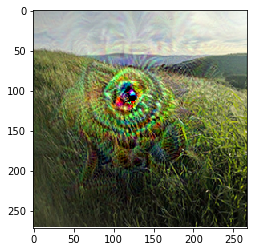

In [4]:
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.

base_image_path = 'a.png'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

plt.imshow(deprocess_image(np.copy(img)))
plt.show()
